In [1]:
import pandas as pd
import pandahouse
import seaborn as sns
import numpy as np
from scipy import stats #статистика

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230720'
}

## AA-тест

In [3]:
# Выгружаем пользователь из 2 и 3 группы для проведения АА-теста

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-06-23' and '2023-06-29'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

group_2 = df[df.exp_group == 2].copy()
group_3 = df[df.exp_group == 3].copy()

In [4]:
df

,exp_group,user_id,likes,views,ctr
0,3,115383,38,248,0.153226
1,3,10326,24,132,0.181818
2,3,123580,25,122,0.204918
3,2,131473,19,98,0.193878
4,2,23985,12,44,0.272727
...,...,...,...,...,...
16782,3,122008,20,123,0.162602
16783,2,25383,2,18,0.111111
16784,3,122190,15,56,0.267857
16785,2,108927,16,51,0.313725


In [5]:
df.groupby('exp_group').user_id.count()

exp_group
2    8362
3    8425
Name: user_id, dtype: int64

In [8]:
# Сделаем графики в seaborn 
sns.set(rc={'figure.figsize':(18,12)})

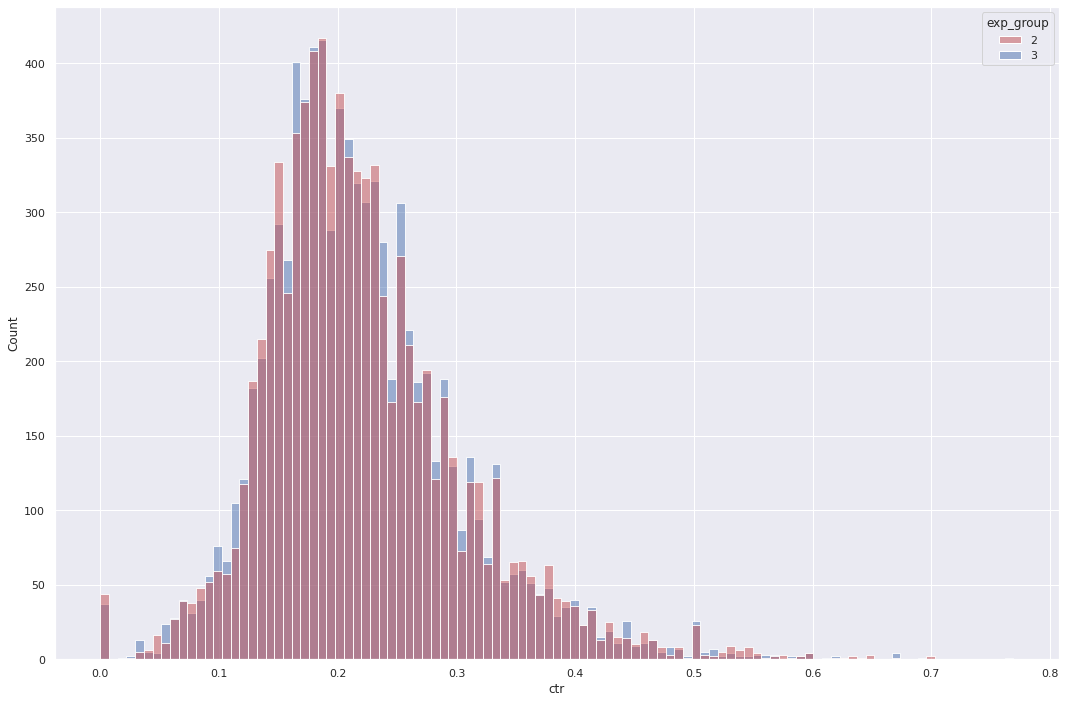

In [9]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [10]:
stats.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.6617303509169771, pvalue=0.5081531382926281)

Визуально и статистически (pvalue=0.508) группы пользователей 2 и 3 похожи/ различия допустимы

## 10000 АА-тестов

In [11]:
# Проведем 10000 тестов на выборках по 500 пользователей в групппах 2 и 3
# frac - доля от общего количества датафрейма (группы)

ps_values = []

for i in range(10000):
    _, p_value = stats.ttest_ind(group_2.ctr.sample(frac=0.06, replace=True),
                                group_3.ctr.sample(frac=0.06, replace=True),
                                equal_var = False)
    ps_values.append(p_value)

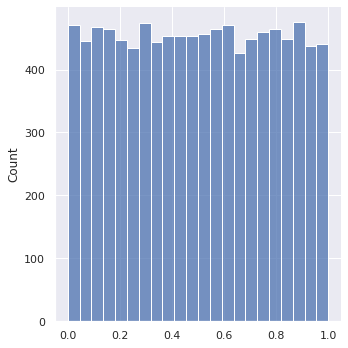

In [12]:
sns.displot(ps_values)

In [13]:
# найдем количество p-value, которые меньше или равны 0,05.

sum(np.array(ps_values)<=0.05)/10000

0.0515

## Вывод
Значения p-value распределены достаточно равномерно и около 5% p-value оказались меньше или равны 0,05. Из этого следует, что АА-тест проведен успешно, пользователи разбиты на статистически равные группы, что позволяет проводить АВ-тест на этих или других группах из этой разбивки пользователей.